# Milestone Project 1: Food Vision Big

## Check GPU

Remember: For mixed Precision training we need a Tesla t4 GPU because it has GPU score of 7.5 and we need a score of 7.0+

## Get heper functins

In past modeules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather thn rewrite all of these, we can import a script and load them in from there.

The scrit can be found on our Github:https://github.com/bluehat-1/Deep-earning

In [1]:
# Download helper function script
!wget https://raw.githubusercontent.com/bluehat-1/Deep-earning/main/helper_functions_sou.py

--2025-03-13 02:07:50--  https://raw.githubusercontent.com/bluehat-1/Deep-earning/main/helper_functions_sou.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607 (13K) [text/plain]
Saving to: ‘helper_functions_sou.py.1’

helper_functions_so 100%[===================>]  13.29K  --.-KB/s    in 0s      

2025-03-13 02:07:50 (26.0 MB/s) - ‘helper_functions_sou.py.1’ saved [13607/13607]



In [2]:
# Import series of helper functions for the notebook
from helper_functions_sou import plot_loss_curves, compare_historys

## Use TensorFlow Dataset to Download Data

If you want to get an overview of TensorFlow Dataset, read the guide: https://www.tensorflow.org/datasets/overview

In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets ?

True


In [5]:
# Load in the data (takes 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train","validation"],
                                            shuffle_files = True,
                                            as_supervised = True, # data gets returned in tuple format (data, labels)
                                            with_info=True)

## Exploring the Food101 data from Tensorflow Datasets

To become one with our data, we want to find:
* class_names
* The shape of our input data (image_tensors)
* The datatype of our input data
* what the labels looks like (e.g. are they one-hot encoded or are they label encoded)
* do the labels match with class names

In [6]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [9]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
 # Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image shape : {image.shape},
    Image datatype: {image.dtype }
    Target class from Food101 (tensor form): {label}
    Class name (str form) : {class_names[label.numpy()]}
    """)


   Image shape : (512, 384, 3),
   Image datatype: <dtype: 'uint8'>
   Target class from Food101 (tensor form): 19
   Class name (str form) : chicken_quesadilla
   


In [11]:
 # What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  7,   7,   5],
        [ 11,  11,   9],
        [ 14,  14,  12]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  5,   5,   3],
        [  8,   8,   6],
        [ 11,  11,   9]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  5,   5,   3],
        [  7,   7,   5],
        [ 10,  10,   8]],

       ...,

       [[ 72,  75,  82],
        [ 55,  58,  65],
        [ 43,  46,  51],
        ...,
        [105, 113, 115],
        [108, 113, 116],
        [135, 140, 143]],

       [[ 75,  80,  86],
        [ 61,  66,  72],
        [ 51,  54,  59],
        ...,
        [102, 107, 110],
        [ 75,  79,  82],
        [111, 115, 118]],

       [[ 94,  99, 105],
        [ 81,  86,  92],
        [ 71,  74,  79],
        ...,
        [151, 156, 15

In [12]:
# what are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

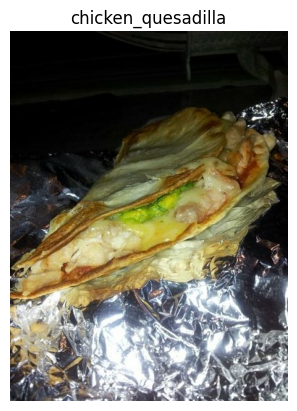

In [13]:
# Let's plot one of the image from the training dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False); 

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing function and map it to your data.

What we know about our data:
* It is in `uint-8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know model like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensor generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using EfficientNetB0 pretrained model from tf.keras.applications we don't need to rescale our data(these architecture have rescaling layer built-in)

This means our function need to:
1. Reshape our images to all of the same size
2. Convert the dtype of our image tensors from `uint-8` to `float32`.

In [14]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Convert image datatype from 'uint8' -> 'float32' and reshape
    image to [img_shape, img_shape, color_channel]
    """
    image = tf.image.resize(image, [img_shape, img_shape])  # reshape target image
    #image = image/255. # scale image values (not required with EfficientNetB0)
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [15]:
# Preprocess a single image nd check the output
preprocessed_image = preprocess_img(image, label)[0]

print(f"Image before preprocessing:\n {image[:2]}...., \nshape:{image.shape}, \nDatatype: {image.dtype}")
print(f"Image before preprocessing:\n {preprocessed_image[:2]}...., \nshape:{preprocessed_image.shape}, \nDatatype: {preprocessed_image.dtype}")

Image before preprocessing:
 [[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 7  7  5]
  [11 11  9]
  [14 14 12]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 5  5  3]
  [ 8  8  6]
  [11 11  9]]]...., 
shape:(512, 384, 3), 
Datatype: <dtype: 'uint8'>
Image before preprocessing:
 [[[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 7.7907934  7.7907934  5.7907934]
  [ 5.714286   5.714286   3.7142856]
  [10.999987  10.999987   8.999987 ]]

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 6.770399   6.770399   4.770399 ]
  [ 6.790833   6.790833   4.790833 ]
  [10.1887665 10.1887665  8.1887665]]]...., 
shape:(224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & Prepare Dataset

We're now going to make our data input pipeline run really fast.

For more resources on this, go through this : https://www.tensorflow.org/guide/data_performance

In [16]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shufflw a number of elements and then batch them togetherand finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch". 

## Create Modelling callback

We're going to create callbacks to help us while our model trains:
* ModelCheckpoint callback to save our model's progress after feature extraction

In [18]:
# Create ModelCheckpint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor = 'val_acc',
                                                     save_best_only = True,
                                                     save_weights_only = True,
                                                     verbose=0) # don't print whether or not model is being saved


## Setup mixed precision training

First and foremost, for a deeper understanding, check out the TensorFlow guide for mixed precision:
https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [19]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [20]:
!nvidia-smi


Thu Mar 13 02:08:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             29W /   70W |     105MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [22]:
# Let's build a feature extraction model
input_shape = (224, 224,3)

from tensorflow.keras import layers

# create base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.Input(shape = input_shape, name = "input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below:
# x = layers.Rescaling(1/255.)(x)

x = base_model(inputs, training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
# Let's compile our model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # we use sparse because our labels aren't one hot encoded
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ["accuracy"])

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [25]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


Going throught the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not ? (if `False`, the weights are frozen)
* `layer.dtype`: the datatype a layer stores its variable in
* `layer.dtype_policy`: the data type policy a layer computes on its variable with

In [26]:
# Check dtype_policy attributes of layers in base model
for layer in model.layers[1].layers:
    print(layer.name, layer.dtype, layer.dtype_policy )

input_layer float32 <DTypePolicy "mixed_float16">
rescaling float32 <DTypePolicy "mixed_float16">
normalization float32 <DTypePolicy "mixed_float16">
rescaling_1 float32 <DTypePolicy "mixed_float16">
stem_conv_pad float32 <DTypePolicy "mixed_float16">
stem_conv float32 <DTypePolicy "mixed_float16">
stem_bn float32 <DTypePolicy "mixed_float16">
stem_activation float32 <DTypePolicy "mixed_float16">
block1a_dwconv float32 <DTypePolicy "mixed_float16">
block1a_bn float32 <DTypePolicy "mixed_float16">
block1a_activation float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze float32 <DTypePolicy "mixed_float16">
block1a_se_reshape float32 <DTypePolicy "mixed_float16">
block1a_se_reduce float32 <DTypePolicy "mixed_float16">
block1a_se_expand float32 <DTypePolicy "mixed_float16">
block1a_se_excite float32 <DTypePolicy "mixed_float16">
block1a_project_conv float32 <DTypePolicy "mixed_float16">
block1a_project_bn float32 <DTypePolicy "mixed_float16">
block2a_expand_conv float32 <DTypePolicy "m

## Fit the Featur extraction model

if our goal is to  fine-tune a pretrained model, the general order of doing thing is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [27]:
# Let's set steps_per_epoch
import math
steps_per_epoch = math.ceil(75750/32)

In [28]:
# Fit the feature extraction model with callbacks
train_data_repeat = train_data.repeat()
history = model.fit(train_data_repeat,
                   epochs=5,
                   steps_per_epoch = len(train_data),
                   validation_data = test_data,
                   validation_steps = int(0.15*len(train_data)),
                   callbacks=model_checkpoint)

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 118s 40ms/step - accuracy: 0.4350 - loss: 2.4620 - val_accuracy: 0.6599 - val_loss: 1.2997
Epoch 2/5
   2/2368 ━━━━━━━━━━━━━━━━━━━━ 2:19 59ms/step - accuracy: 0.5938 - loss: 1.6925

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.6271 - loss: 1.4606 - val_accuracy: 0.6859 - val_loss: 1.1818
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - accuracy: 0.6663 - loss: 1.2904 - val_accuracy: 0.6933 - val_loss: 1.1651
Epoch 4/5
   5/2368 ━━━━━━━━━━━━━━━━━━━━ 1:21 34ms/step - accuracy: 0.6696 - loss: 1.3498

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.6881 - loss: 1.1955 - val_accuracy: 0.6938 - val_loss: 1.1317
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.7031 - loss: 1.1253 - val_accuracy: 0.6996 - val_loss: 1.1094


In [29]:
#  Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6963 - loss: 1.1212


[1.117712378501892, 0.6963960528373718]

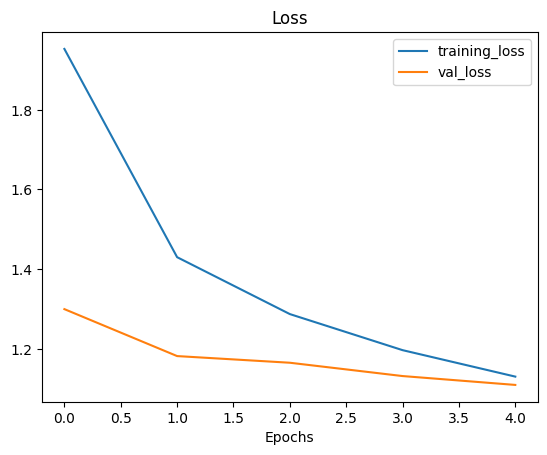

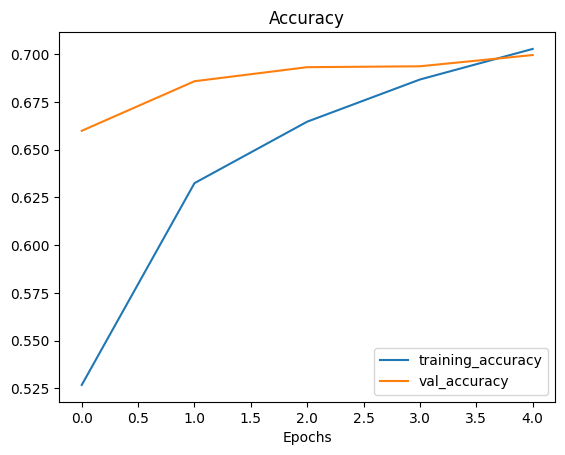

In [30]:
plot_loss_curves(history)

## Let's Fine-Tune our model

In [34]:
# First let's make some layers of our base model trainable
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable= False

In [38]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics = ['accuracy'])

In [40]:
history_1 = model.fit(train_data_repeat,
                     epochs=10,
                     steps_per_epoch = steps_per_epoch,
                     validation_data = test_data,
                     validation_steps = int(0.15*len(test_data)),
                     initial_epoch = history.epoch[-1],
                     callbacks=model_checkpoint)

Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 109s 37ms/step - accuracy: 0.7004 - loss: 1.1352 - val_accuracy: 0.7203 - val_loss: 1.0441
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.7499 - loss: 0.9463 - val_accuracy: 0.7262 - val_loss: 1.0088
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - accuracy: 0.7698 - loss: 0.8608 - val_accuracy: 0.7288 - val_loss: 0.9842
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - accuracy: 0.7922 - loss: 0.7854 - val_accuracy: 0.7423 - val_loss: 0.9502
Epoch 9/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.8088 - loss: 0.7258 - val_accuracy: 0.7381 - val_loss: 0.9548
Epoch 10/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.8207 - loss: 0.6865 - val_accuracy: 0.7352 - val_loss: 0.9567


In [41]:
# Let's evaluate on complete test data
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.7414 - loss: 0.9588


[0.9565463066101074, 0.7417821884155273]

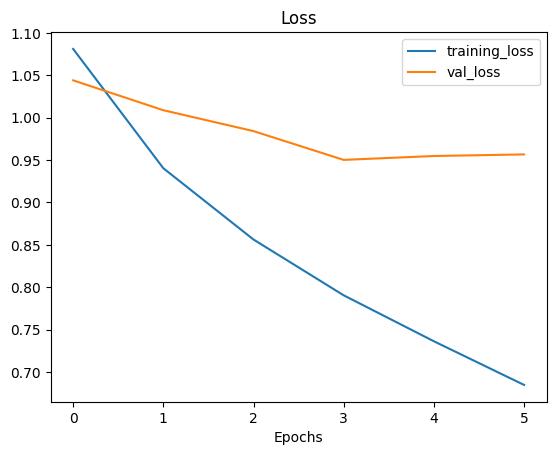

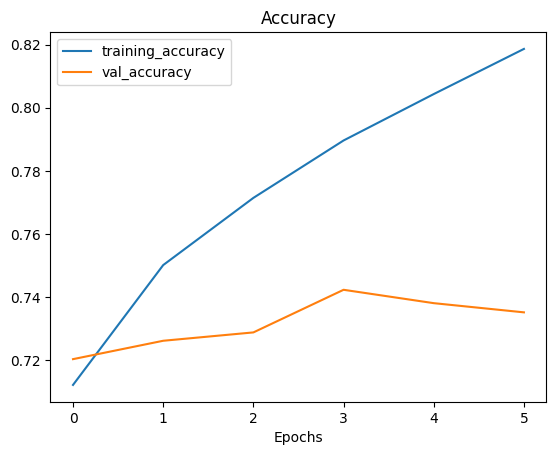

In [42]:
# Let's plot loss curves
plot_loss_curves(history_1)

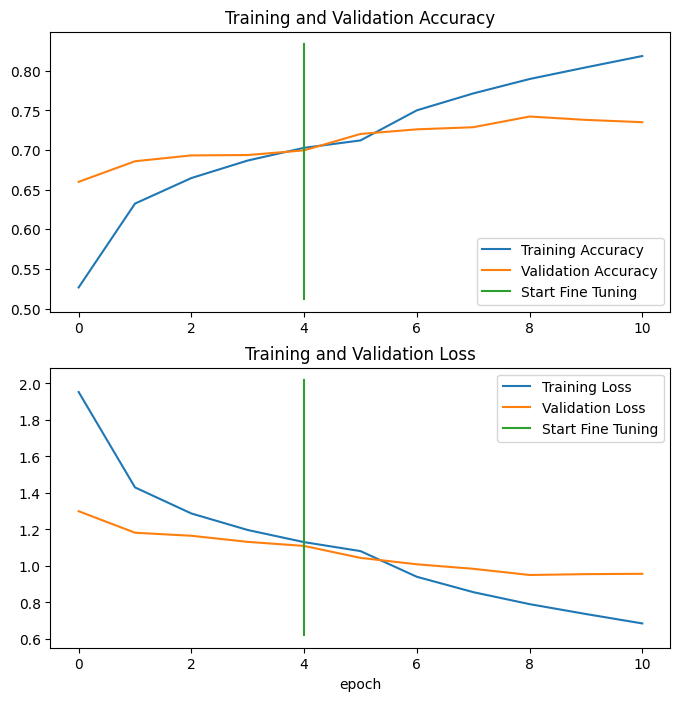

In [44]:
# Let's comare histories
compare_historys(history, history_1)

There is some improvement in our fine tune model as compare to feature extraction model

## Let's predict on custom images

In [53]:
# First let's build a function to preprocess and plot prediction
def pred_and_plot(model, filename):
    image = tf.io.read_file(filename)
    image = tf.io.decode_image(image)
    image = tf.image.resize(image,[224,224])
    image = tf.expand_dims(image, axis=0)

    pred = model.predict(image)
    pred_class = class_names[pred.argmax()]

    img = mpimg.imread(filename)
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

In [48]:
# downloading custom images
from helper_functions_sou import unzip_data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2025-03-13 02:46:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 108.177.12.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2025-03-13 02:46:48 (88.9 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [49]:
!ls custom_food_images

chicken_wings.jpeg  pizza-dad.jpeg  steak.jpeg
hamburger.jpeg	    ramen.jpeg	    sushi.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


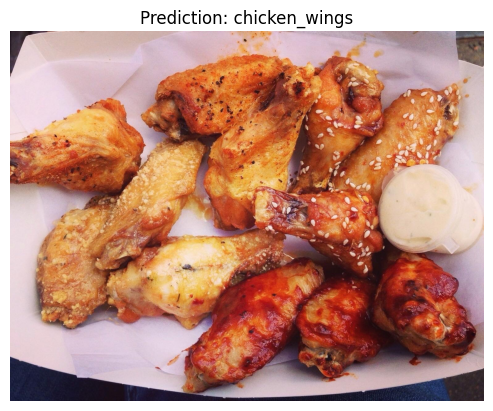

In [54]:
pred_and_plot(model, "custom_food_images/chicken_wings.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


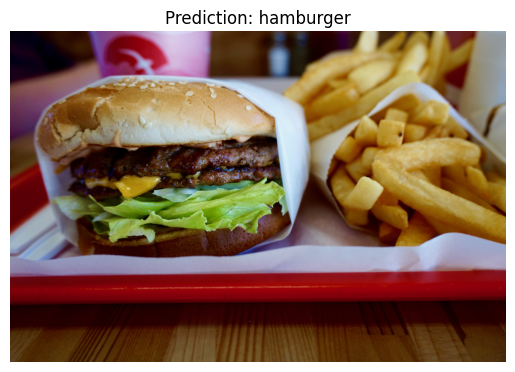

In [55]:
pred_and_plot(model, "custom_food_images/hamburger.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


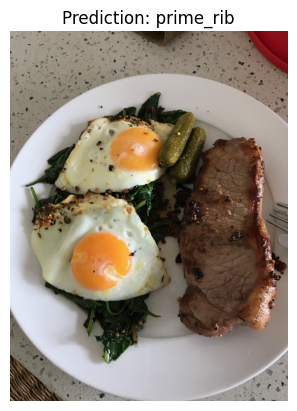

In [56]:
pred_and_plot(model, "custom_food_images/steak.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


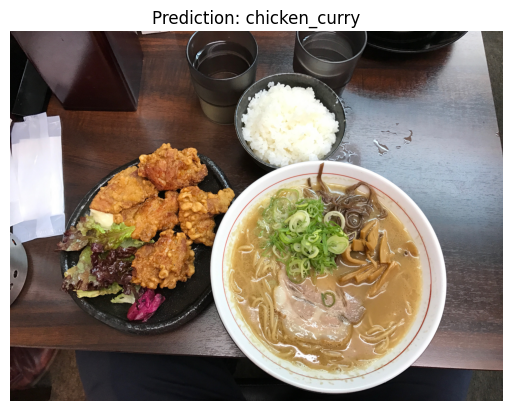

In [57]:
pred_and_plot(model, "custom_food_images/ramen.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


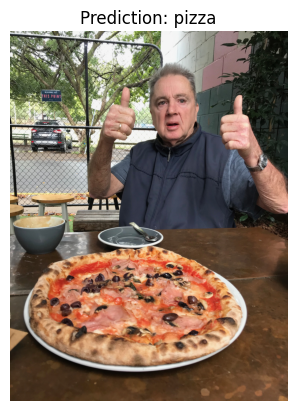

In [59]:
pred_and_plot(model, "custom_food_images/pizza-dad.jpeg")

In [60]:
model.save("Food_101_trained_model.h5")

In [62]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [63]:
!wget https://raw.githubusercontent.com/bluehat-1/Deep-earning/main/hamburger.jpg

--2025-03-13 02:57:16--  https://raw.githubusercontent.com/bluehat-1/Deep-earning/main/hamburger.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12343 (12K) [image/jpeg]
Saving to: ‘hamburger.jpg’

hamburger.jpg       100%[===================>]  12.05K  --.-KB/s    in 0s      

2025-03-13 02:57:17 (84.3 MB/s) - ‘hamburger.jpg’ saved [12343/12343]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


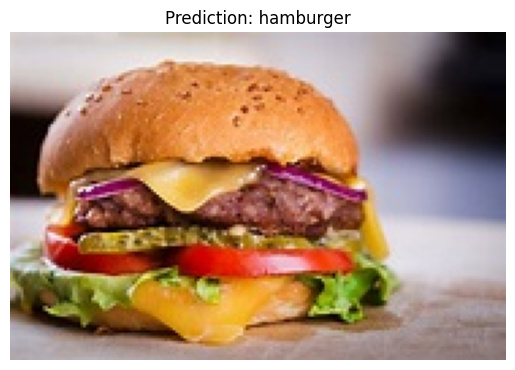

In [65]:
pred_and_plot(model,"hamburger.jpg" )

In [66]:
!wget https://raw.githubusercontent.com/bluehat-1/Deep-earning/main/samosa.jpg

--2025-03-13 03:00:16--  https://raw.githubusercontent.com/bluehat-1/Deep-earning/main/samosa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13064 (13K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  12.76K  --.-KB/s    in 0s      

2025-03-13 03:00:16 (86.7 MB/s) - ‘samosa.jpg’ saved [13064/13064]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


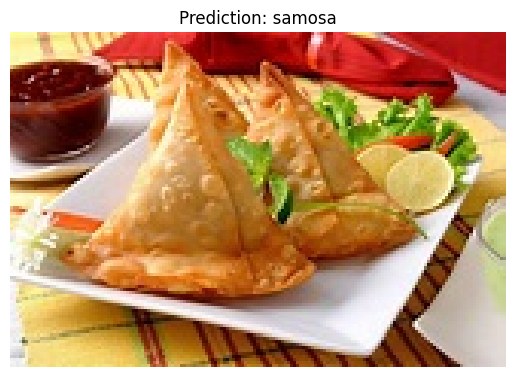

In [67]:
pred_and_plot(model, "samosa.jpg")

In [68]:
!wget https://raw.githubusercontent.com/bluehat-1/Deep-earning/main/spring_roll.jpg

--2025-03-13 03:01:29--  https://raw.githubusercontent.com/bluehat-1/Deep-earning/main/spring_roll.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9790 (9.6K) [image/jpeg]
Saving to: ‘spring_roll.jpg’

spring_roll.jpg     100%[===================>]   9.56K  --.-KB/s    in 0s      

2025-03-13 03:01:29 (70.4 MB/s) - ‘spring_roll.jpg’ saved [9790/9790]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


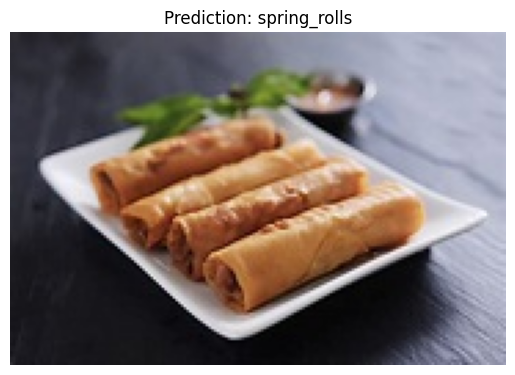

In [69]:
pred_and_plot(model, "spring_roll.jpg")